# Ridge regression

In [2]:
import spotipy
import spotipy.util as util
import time
import timeit
import pandas as pd 
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import json
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing

In [3]:
# load data csv

df = pd.read_csv('df_by_playlist.csv')
print('dataframe has shape', df.shape)

dataframe has shape (1602, 63)


In [4]:
names = list(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness',
       'tempo', 'valence', 'explicit', 'mode', 'num_tracks',
       'track_feat', 'track_remast', 'track_remix', 'album_feat',
       'album_deluxe', 'album_best', 'time_sign_0.0', 'time_sign_3.0',
       'time_sign_4.0', 'key_0.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0',
       'key_5.0', 'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0','key_11.0'])

In [5]:
# normalize the (un-normalized) continuous data

colnames = ['duration_ms','popularity','tempo','num_tracks']
for name in colnames:
    df[name] = df[name]/max(df[name])

In [6]:
# add some interaction terms

quant_predictors = list([predictor for predictor in names if df.loc[:,predictor].unique().sum()!=1])

def interact(x,variable,predictors=quant_predictors):
    for predictor in predictors:
        x[variable+'_'+predictor] = x[variable]*x[predictor]
    return x

df = interact(df,'loudness')
df = interact(df,'danceability',list(['speechiness','tempo']))
df = interact(df,'loudness')
df = interact(df,'danceability',list(['speechiness','tempo']))

print('dataframe has shape', df.shape)

dataframe has shape (1602, 77)


In [7]:
# add polynomial features for continuous data

polydf = pd.DataFrame(df[quant_predictors])

deg = 2

poly = PolynomialFeatures(degree=deg)
polydftrans = poly.fit_transform(polydf)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(polydf.columns,p) for p in poly.powers_]]
polydf = pd.DataFrame(polydftrans, columns = target_feature_names)

df = df.join(polydf)
df = df.drop(colnames,axis=1)
print('dataframe with continuous variable polynomial features has size', df.shape)

dataframe with continuous variable polynomial features has size (1602, 164)


In [8]:
# 80/20 train/test split

Xtr, Xte, ytr, yte = train_test_split(df.drop(['followers','playlist_name'],axis=1), df['followers'], test_size=0.2, random_state=1)

print('training set: predictors dataframe has shape', Xtr.shape)
print('test set: predictors dataframe has shape', Xte.shape)

training set: predictors dataframe has shape (1281, 162)
test set: predictors dataframe has shape (321, 162)


# Fit model

In [9]:
# do base line fit using only popularity

X_test = Xte['popularity^1']; X_test = sm.add_constant(X_test)
y_test = np.log(yte)
X_train = Xtr['popularity^1']; X_train = sm.add_constant(X_train)
y_train = np.log(ytr)

start = timeit.default_timer()
model = RidgeCV(alphas=(1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4,1e5))
model.fit(X_train,y_train)

predtrain = model.predict(X_train)
predtest = model.predict(X_test)
stop = timeit.default_timer()

R2train = r2_score(y_train,predtrain)
R2test = r2_score(y_test,predtest)
#print('Ridge alpha value is',model.alpha_)
print('R2 on training set is',R2train)
print('R2 on test set is',R2test)
print('took',stop - start,'seconds')

R2 on training set is 0.203491368866
R2 on test set is 0.126163807149
took 0.03420959087088704 seconds


In [10]:
# do fit using all predictors

X_test = Xte; X_test = sm.add_constant(X_test)
y_test = np.log(yte)
X_train = Xtr; X_train = sm.add_constant(X_train)
y_train = np.log(ytr)

start = timeit.default_timer()
model = RidgeCV(alphas=(1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4,1e5))
model.fit(X_train,y_train)

predtrain = model.predict(X_train)
predtest = model.predict(X_test)
stop = timeit.default_timer()

R2train = r2_score(y_train,predtrain)
R2test = r2_score(y_test,predtest)
print('Ridge alpha value is',model.alpha_)
print('R2 on training set is',R2train)
print('R2 on test set is',R2test)
print('took',stop - start,'seconds')

Ridge alpha value is 0.1
R2 on training set is 0.56276084744
R2 on test set is 0.484277552849
took 0.03000124916434288 seconds


In [11]:
# cross_val_score on training set

CVscore = cross_val_score(model,X_train,y_train)
print('CV scores are',CVscore)
print('mean CV score is', np.mean(CVscore))

CV scores are [ 0.46384187  0.47141176  0.40788326]
mean CV score is 0.447712299801


[<matplotlib.text.Text at 0x11e4e18d0>, <matplotlib.text.Text at 0x11e3e3828>]

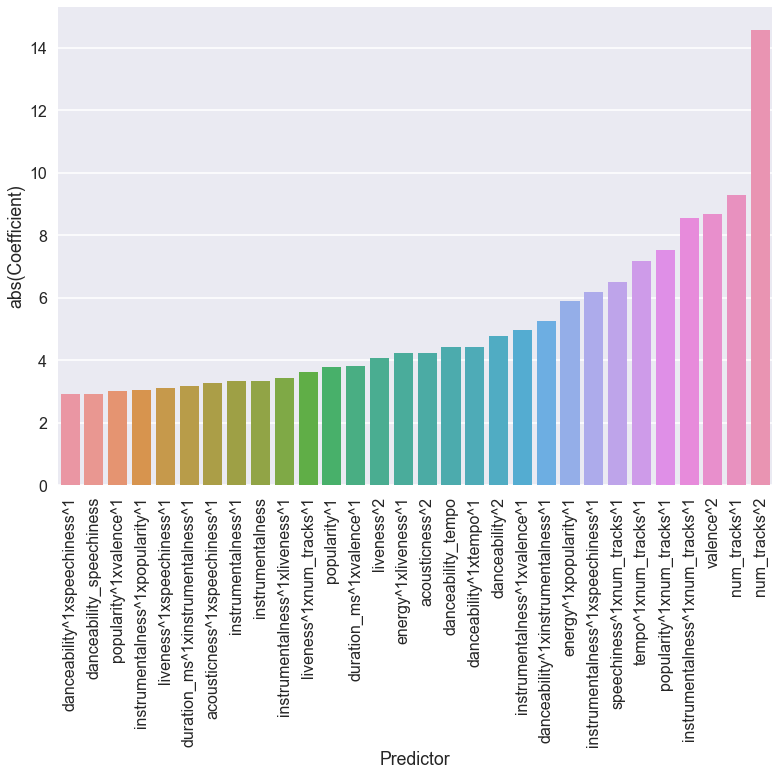

In [35]:
# check out importance of predictors

# important predictors
sns.set_context("poster",font_scale=1)

num=30
predictors = list(X_train)
coefficients = abs(model.coef_)
df_ = pd.DataFrame(coefficients,predictors)
df_ = df_.sort_values(0)
fig = sns.barplot(x=df_.index[-num:],y=df_[0][-num:],data=df_)

for item in fig.get_xticklabels():
    item.set_rotation(90)

fig.set(xlabel='Predictor', ylabel='abs(Coefficient)')

[<matplotlib.text.Text at 0x11894eb70>, <matplotlib.text.Text at 0x118807ba8>]

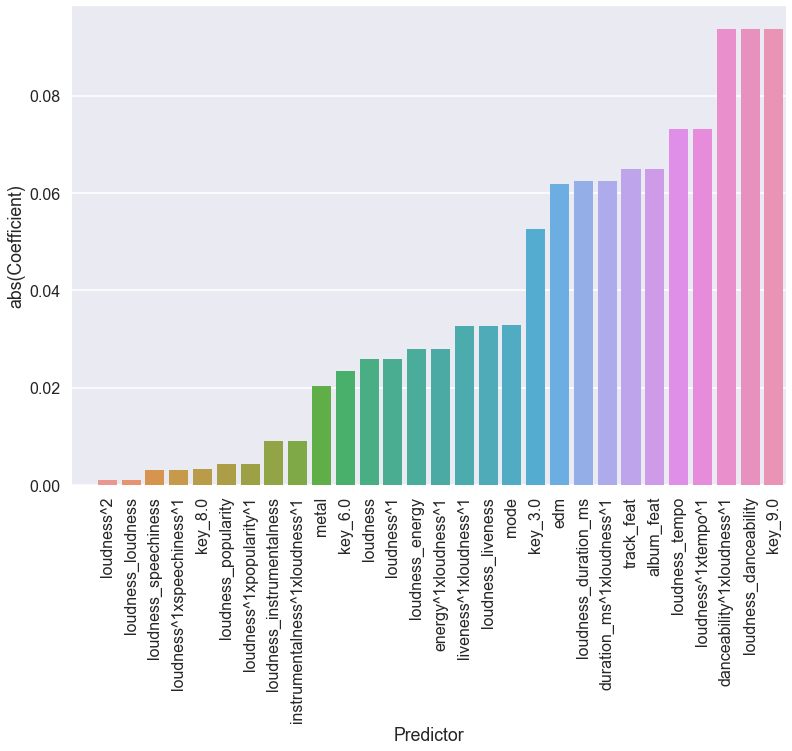

In [36]:
# unimportant predictors

# important predictors
sns.set_context("poster",font_scale=1)

num=30
predictors = list(X_train)
coefficients = abs(model.coef_)
df_ = pd.DataFrame(coefficients,predictors)
df_ = df_.sort_values(0)
fig = sns.barplot(x=df_.index[0:num],y=df_[0][0:num],data=df_)

for item in fig.get_xticklabels():
    item.set_rotation(90)

fig.set(xlabel='Predictor', ylabel='abs(Coefficient)')